In [129]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#import
import javabridge
import bioformats
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy
import os

javabridge.start_vm(class_path=bioformats.JARS)
from tifffile import imsave
from tifffile import imread
from PIL import Image

from  functions_super_res_create_training_im import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

In [131]:
import warnings
warnings.filterwarnings('ignore')

In [132]:
from torchvision.models import vgg16_bn

In [133]:
torch.cuda.set_device(2)

Image sizes: 
- HR training: (1004, 1344, 6)
- LR training: (500, 669, 6)

In [134]:
#path = Path('../../../../../datasets2/ImageNet_links')
path = Path('../../data/train/HR')
#path_hr = path/'test'

#path_lr = path/'small-64/train'
#path_mr = path/'small-256/train'

path_lr = path/'HR_patches_resized/jpg_images'
path_hr = path/'HR_patches_train/jpg_images'
path_mr = path/'HR_patches_resized_model'
#path_lr = path/'HR_patches_resized'

assert path.exists(), f"need dataset @ {path}"


In [135]:
#Images in lr folder test: 
il = ImageList.from_folder(path_hr)

In [136]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality = 60)

In [137]:
# create smaller image sets the first time this nb is run
p = path_mr
size = 256
if not p.exists(): 
    print(f"resizing to {size} into {p}")
    parallel(partial(resize_one, path=p, size=size), il.items)


resizing to 256 into ../../data/train/HR/HR_patches_resized_model


In [139]:
# LR image is (500, 669, 6)
# HR image is (1004, 1344, 6)

free = gpu_mem_get_free_no_cache()

# the max size of the test image depends on the available GPU RAM 
if free > 8200: bs,size=16,256  
else:           bs,size=8,256
print(f"using bs={bs}, size={size}, have {free}MB of GPU RAM free")

arch = models.resnet34
# sample = 0.1
sample = False

using bs=16, size=256, have 12185MB of GPU RAM free


In [140]:
# transformations, had to remove affine, because bugs, not present in model training as well
# Remove affine transformations:
tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [141]:
src = ImageImageList.from_folder(path_mr)

In [142]:
verify_images(path_mr)

In [143]:
verify_images(path_hr)

In [144]:
if sample: src = src.filter_by_rand(sample, seed=42)

In [145]:
src = src.split_by_rand_pct(0.1, seed=42)

In [146]:
src

ItemLists;

Train: ImageImageList (427 items)
Image (3, 256, 342),Image (3, 256, 342),Image (3, 256, 342),Image (3, 256, 342),Image (3, 256, 342)
Path: ../../data/train/HR/HR_patches_resized_model;

Valid: ImageImageList (47 items)
Image (3, 256, 342),Image (3, 256, 342),Image (3, 256, 342),Image (3, 256, 342),Image (3, 256, 342)
Path: ../../data/train/HR/HR_patches_resized_model;

Test: None

In [147]:
def get_data(bs,size):
    #data = (src.label_from_func(lambda x: path_hr/x.relative_to(path_lr)).transform(get_transforms(max_zoom=2.), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data = (src.label_from_func(lambda x: path_hr/x.relative_to(path_mr))
            .transform(tfms, size=size, tfm_y=True).databunch(bs=bs)
            .normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [148]:
data = get_data(bs,size)

In [149]:
data

ImageDataBunch;

Train: LabelList (427 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: ../../data/train/HR/HR_patches_resized_model;

Valid: LabelList (47 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: ../../data/train/HR/HR_patches_resized_model;

Test: None

## Feature loss:

In [150]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [151]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [152]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [153]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train:

In [154]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [155]:
learn.unfreeze()

In [156]:
# relies on first running lesson7-superres.ipynb which created the following model
learn.load((untar_data(URLs.PETS)/'small-96'/'models'/'2b').absolute());

In [157]:
learn.fit_one_cycle(1, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.054033,0.969016,0.119770,0.152953,0.158002,0.027713,0.265327,0.232231,0.013020,00:38


In [161]:
learn.save('super_res')

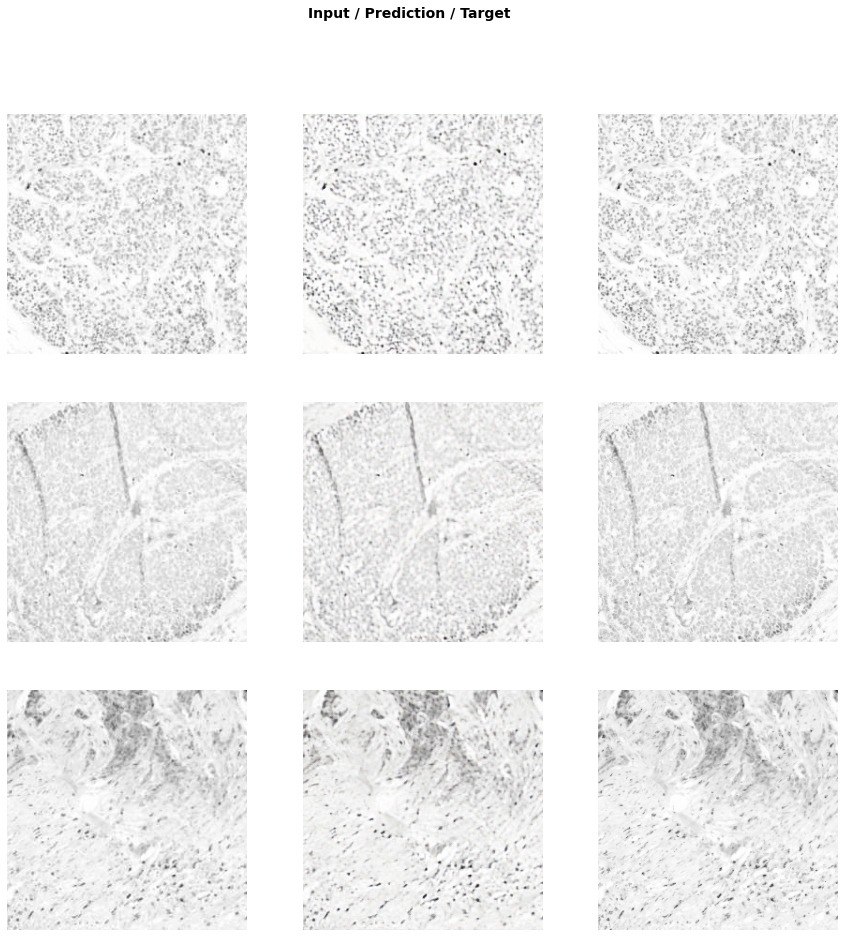

In [159]:
learn.show_results(rows=3, imgsize=5)

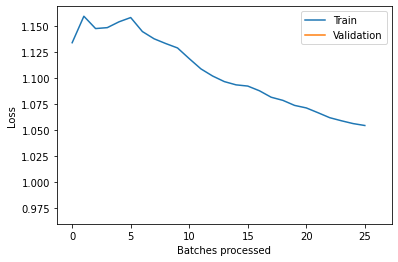

In [160]:
learn.recorder.plot_losses()

## Test:

In [163]:
_=learn.load('super_res')

In [164]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.relative_to(path_mr))
          .transform(tfms, size=(820,1024), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [165]:
learn.data = data_mr

In [166]:
# here put some image you want to enhance, e.g. the original notebook uses a single video frame from a powerpoint presentation on dropout paper
fn = path_lr/'0013_[39667,16250]_-0.jpg'

In [167]:
img = open_image(fn); img.shape

torch.Size([3, 500, 669])

In [168]:
_,img_hr,b = learn.predict(img)

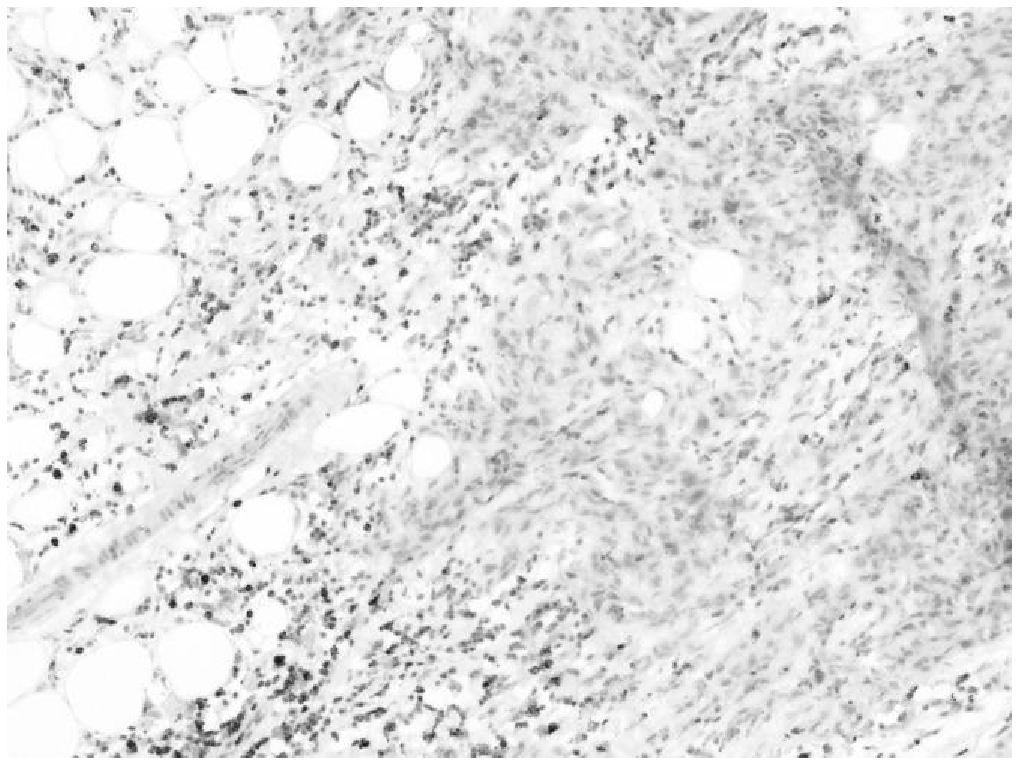

In [169]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


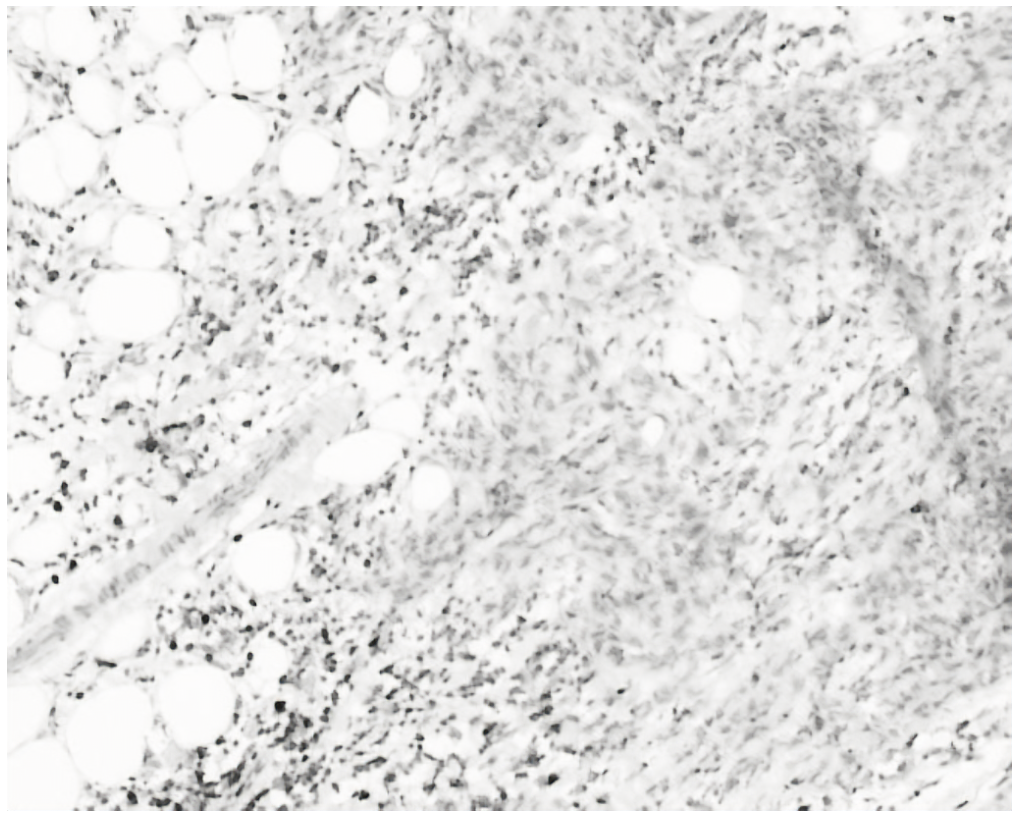

In [170]:
Image(img_hr).show(figsize=(18,15))